# UNSW-NB15: Data cleaning and preprocessing

## Importing libraries

In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats
import os
import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

## Reading data

In [2]:
# Creating a empty dict, where I will save all parameters required for test data transformation

saved_dict = {}

In [3]:
# Reading datasets
dfs = []
for i in range(1,5):
    path = './UNSW-NB15_{}.csv'  # There are 4 input csv files
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df

In [4]:
file_info = []

for i in range(1, 5):

    path = f'./UNSW-NB15_{i}.csv'
    
    df = pd.read_csv(path, header=None)
    
    file_size_mb = os.path.getsize(path) / (1024 * 1024)
    
    num_records = df.shape[0]
    
    num_features = df.shape[1]
    
    file_info.append({
        'file_name': f'UNSW-NB15_{i}.csv',
        'file_size_mb': round(file_size_mb, 1),
        'num_records': num_records,
        'num_features': num_features
    })

file_info_df = pd.DataFrame(file_info)

columns_to_display = ['file_name', 'file_size_mb', 'num_records', 'num_features']

print(file_info_df[columns_to_display])


         file_name  file_size_mb  num_records  num_features
0  UNSW-NB15_1.csv         161.2       700001            49
1  UNSW-NB15_2.csv         157.6       700001            49
2  UNSW-NB15_3.csv         147.4       700001            49
3  UNSW-NB15_4.csv          93.1       440044            49


In [5]:
# This csv file contains names of all the features
df_col = pd.read_csv('./UNSW-NB15_features.csv', encoding='ISO-8859-1')

In [6]:
# Making column names lower case, removing spaces
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

In [7]:
# Renaming our dataframe with proper column names
all_data.columns = df_col['Name']

In [8]:
# Saving useful info, later this will be used to transform raw test data
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()

In [9]:
del df_col

In [10]:
all_data.shape

(2540047, 49)

In [11]:
all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


## Data cleaning and pre-processing

In [12]:
# Splitting data into train and test
# All the operation like cleaning, EDA and FE will be done on train data only

train, test = train_test_split(all_data, test_size=0.3, random_state=16)

In [13]:
# Deleting the concatenated dataframe, as we don't need that anymore
del all_data

In [14]:
print(train.shape,'\n',test.shape)

(1778032, 49) 
 (762015, 49)


In [15]:
# checking for null values
train.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

## Filling Null values

In [16]:
train['attack_cat'].value_counts()

Generic             150906
Exploits             31507
 Fuzzers             13345
DoS                  11433
 Reconnaissance       8544
 Fuzzers              3569
Analysis              1855
Backdoor              1242
Reconnaissance        1220
 Shellcode             904
Backdoors              374
Shellcode              151
Worms                  120
Name: attack_cat, dtype: int64

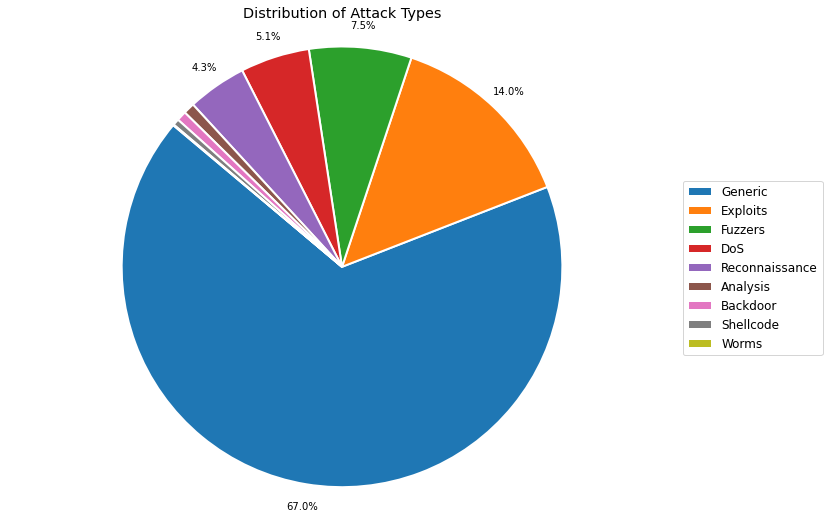

In [17]:
import matplotlib.pyplot as plt

contagens = pd.Series({
    'Generic': 150906, 'Exploits': 31507, 'Fuzzers': 13345 + 3569,
    'DoS': 11433, 'Reconnaissance': 8544 + 1220, 'Analysis': 1855,
    'Backdoor': 1242 + 374, 'Shellcode': 904 + 151, 'Worms': 120
})


contagens_sorted = contagens.sort_values(ascending=False)


fig, ax = plt.subplots(figsize=(12, 9))
wedges, texts, autotexts = ax.pie(
    contagens_sorted,
    autopct=lambda pct: f'{pct:.1f}%' if pct > 1 else '',  
    startangle=140,
    pctdistance=1.1, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}  
)


for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_size('medium')  

#ax.legend(wedges, contagens_sorted.index, title="", loc="center left", bbox_to_anchor=(1, 0.5))
ax.legend(wedges, contagens_sorted.index, title="", loc="center left", bbox_to_anchor=(1, 0.5), fontsize='large')


ax.set_title('Distribution of Attack Types', size='x-large')
ax.axis('equal')  

plt.show()


In [18]:
# We don't have "normal" values for "attack_cat", so we must fill Null values with "normal"
train['attack_cat'] = train.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

In [19]:
train['attack_cat'].value_counts()

normal            1552862
generic            150906
exploits            31507
fuzzers             16914
dos                 11433
reconnaissance       9764
analysis             1855
backdoor             1242
shellcode            1055
backdoors             374
worms                 120
Name: attack_cat, dtype: int64

In [20]:
train['ct_flw_http_mthd'] = train.ct_flw_http_mthd.fillna(value=0)

In [21]:
# Even though it's a binary column, but there're values like 2 and 4
train['is_ftp_login'].value_counts()

0.0    746536
1.0     30329
4.0       109
2.0        21
Name: is_ftp_login, dtype: int64

In [22]:
train['is_ftp_login'] = (train.is_ftp_login.fillna(value=0)).astype(int)

In [23]:
# There are no Null values in the train data anymore
train.isnull().sum().sum()

0

## Information about dataset

In [24]:
# Getting name of all the columns
train.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'label'],
      dtype='object', name='Name')

## Class distribution

In [25]:
train_0, train_1 = train['label'].value_counts()[0] / len(train.index), train['label'].value_counts()[1] / len(train.index)
test_0, test_1 = test['label'].value_counts()[0] / len(test.index), test['label'].value_counts()[1] / len(test.index)

print("In Train: there are {} % of class 0 and {} % of class 1".format(train_0, train_1))
print("In Test: there are {} % of class 0 and {} % of class 1".format(test_0, test_1))

In Train: there are 0.8733599845222133 % of class 0 and 0.12664001547778667 % of class 1
In Test: there are 0.8738699369434985 % of class 0 and 0.1261300630565015 % of class 1


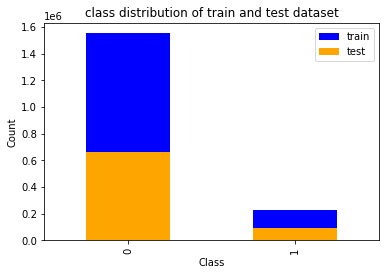

In [26]:
# Plotting target label distribution
plt.figure()
plt.title("class distribution of train and test dataset")
train['label'].value_counts().plot(kind="bar", color='b', label="train")
test['label'].value_counts().plot(kind="bar", color='orange', label="test")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

## Datatype information of the Features

In [27]:
# Check if any null value present in datasets
train.isnull().sum().sum(), test.isnull().sum().sum()  # No Null in train and test data is still raw

(0, 1499013)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1778032 entries, 81030 to 2079982
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit      

In [29]:
# All the datatypes in our dataset
train.dtypes.value_counts()

int64      28
float64    11
object      9
int32       1
dtype: int64

In [30]:
# Categorical feature names
train.select_dtypes(exclude=np.number).columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'ct_ftp_cmd', 'attack_cat'],
      dtype='object', name='Name')

In [31]:
# This is a numerical feature not a categorical
train['ct_ftp_cmd'].unique()

array([0, ' ', 1, '1', '0', 5, 2, 3, 4, '4', 6, '2', 8], dtype=object)

In [32]:
# Removing empty space and converting it to numerical
train['ct_ftp_cmd'] = train['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

In [33]:
train['ct_ftp_cmd'].unique()

array([0, 1, 5, 2, 3, 4, 6, 8])

In [34]:
# Categorical feature names
train.select_dtypes(exclude=np.number).columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'attack_cat'],
      dtype='object', name='Name')

In [35]:
# Numeric features names
train.select_dtypes(include=np.number).columns

Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload',
       'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object', name='Name')

In [36]:
# Info for test data transformation
saved_dict['binary_col'] = ['is_sm_ips_ports', 'is_ftp_login']

## Fixing values of the columns

In [37]:
# see if binary columns are really binary
for col in 'is_sm_ips_ports', 'is_ftp_login':
    print(train[col].value_counts())
    print()

0    1775116
1       2916
Name: is_sm_ips_ports, dtype: int64

0    1747573
1      30329
4        109
2         21
Name: is_ftp_login, dtype: int64



In [38]:
train['is_ftp_login'] = np.where(train['is_ftp_login']>1, 1, train['is_ftp_login'])

In [39]:
train['is_ftp_login'].value_counts()

0    1747573
1      30459
Name: is_ftp_login, dtype: int64

In [40]:
train['service'].value_counts()

-           872286
dns         547094
http        144555
ftp-data     88310
smtp         57160
ftp          34293
ssh          32897
pop3          1076
dhcp           124
ssl            109
snmp            81
radius          27
irc             20
Name: service, dtype: int64

In [41]:
# removing all the "-" and replacing those with "None"
train['service'] = train['service'].apply(lambda x:"None" if x=="-" else x)

In [42]:
train['service'].value_counts()

None        872286
dns         547094
http        144555
ftp-data     88310
smtp         57160
ftp          34293
ssh          32897
pop3          1076
dhcp           124
ssl            109
snmp            81
radius          27
irc             20
Name: service, dtype: int64

In [43]:
# In the research paper there are not 10 unique values
train['attack_cat'].nunique()

11

In [44]:
train['attack_cat'].value_counts()

normal            1552862
generic            150906
exploits            31507
fuzzers             16914
dos                 11433
reconnaissance       9764
analysis             1855
backdoor             1242
shellcode            1055
backdoors             374
worms                 120
Name: attack_cat, dtype: int64

In [45]:
train['attack_cat'] = train['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

## Saving files to disk

In [46]:
train.shape, test.shape

((1778032, 49), (762015, 49))

In [47]:
train.to_csv('./train_alldata_EDA.csv', index=False)
test.to_csv('./test_alldata_EDA.csv', index=False)

In [48]:
with open('./final_ipynb/saved_dict.pkl', 'wb') as file:
    pickle.dump(saved_dict, file)

